<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week2/mobilevnet2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1+cu101
Torchvision Version:  0.6.1+cu101


In [3]:
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive/school_of_ai/eva4-2/week2'


/content/gdrive/My Drive/school_of_ai/eva4-2/week2


In [5]:
raw_folder = '//content/gdrive/My Drive/school_of_ai/eva4-2/week2/'

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = raw_folder + "hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
import torch.nn as nn
import math


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [15]:
def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)
    
    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
        model.load_state_dict(state_dict)
    return model

In [11]:
input_size = 224
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print(len(image_datasets['train']))
print(len(image_datasets['val']))

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
raw_train_dataiter = iter(dataloaders_dict['train'])
val_train_dataiter = iter(dataloaders_dict['val'])

train_images = raw_train_dataiter.next()
val_images = val_train_dataiter.next()
print(train_images[0].shape)
print(val_images[0].shape)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
244
153
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])


In [16]:
model_ft = mobilenet_v2()
print(model_ft)

Downloading: "https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1" to /root/.cache/torch/checkpoints/mobilenetv2_1.0-f2a8633.pth.tar



MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
#inception
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.conv.0.weight
	 features.1.conv.1.weight
	 features.1.conv.1.bias
	 features.1.conv.3.weight
	 features.1.conv.4.weight
	 features.1.conv.4.bias
	 features.2.conv.0.weight
	 features.2.conv.1.weight
	 features.2.conv.1.bias
	 features.2.conv.3.weight
	 features.2.conv.4.weight
	 features.2.conv.4.bias
	 features.2.conv.6.weight
	 features.2.conv.7.weight
	 features.2.conv.7.bias
	 features.3.conv.0.weight
	 features.3.conv.1.weight
	 features.3.conv.1.bias
	 features.3.conv.3.weight
	 features.3.conv.4.weight
	 features.3.conv.4.bias
	 features.3.conv.6.weight
	 features.3.conv.7.weight
	 features.3.conv.7.bias
	 features.4.conv.0.weight
	 features.4.conv.1.weight
	 features.4.conv.1.bias
	 features.4.conv.3.weight
	 features.4.conv.4.weight
	 features.4.conv.4.bias
	 features.4.conv.6.weight
	 features.4.conv.7.weight
	 features.4.conv.7.bias
	 features.5.conv.0.weight
	 features.5.conv.1.wei

In [18]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 3.0516 Acc: 0.5779
val Loss: 1.2544 Acc: 0.7582

Epoch 1/14
----------
train Loss: 0.8330 Acc: 0.7869
val Loss: 0.6440 Acc: 0.8693

Epoch 2/14
----------
train Loss: 0.6352 Acc: 0.8238
val Loss: 0.4011 Acc: 0.8627

Epoch 3/14
----------
train Loss: 0.7638 Acc: 0.7582
val Loss: 0.4670 Acc: 0.8301

Epoch 4/14
----------
train Loss: 0.2913 Acc: 0.8689
val Loss: 0.3201 Acc: 0.8693

Epoch 5/14
----------
train Loss: 0.2532 Acc: 0.9098
val Loss: 0.4293 Acc: 0.8627

Epoch 6/14
----------
train Loss: 0.3494 Acc: 0.8689
val Loss: 0.3567 Acc: 0.8824

Epoch 7/14
----------
train Loss: 0.2300 Acc: 0.8934
val Loss: 0.3968 Acc: 0.8562

Epoch 8/14
----------
train Loss: 0.4223 Acc: 0.8484
val Loss: 0.3864 Acc: 0.8954

Epoch 9/14
----------
train Loss: 0.4533 Acc: 0.8484
val Loss: 0.3741 Acc: 0.8693

Epoch 10/14
----------
train Loss: 0.3730 Acc: 0.8566
val Loss: 0.4353 Acc: 0.8562

Epoch 11/14
----------
train Loss: 0.2403 Acc: 0.8893
val Loss: 0.3121 Acc: 0.8693

Ep

Epoch 0/14
----------
train Loss: 2.6037 Acc: 0.4713
val Loss: 1.0859 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.7120 Acc: 0.5287
val Loss: 0.9959 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6846 Acc: 0.5779
val Loss: 0.7679 Acc: 0.6209

Epoch 3/14
----------
train Loss: 0.7091 Acc: 0.5369
val Loss: 0.6929 Acc: 0.5425

Epoch 4/14
----------
train Loss: 0.7040 Acc: 0.5574
val Loss: 0.6573 Acc: 0.6340

Epoch 5/14
----------
train Loss: 0.6817 Acc: 0.5820
val Loss: 0.6482 Acc: 0.6209

Epoch 6/14
----------
train Loss: 0.6729 Acc: 0.6025
val Loss: 0.6055 Acc: 0.6993

Epoch 7/14
----------
train Loss: 0.6681 Acc: 0.6025
val Loss: 0.6271 Acc: 0.6601

Epoch 8/14
----------
train Loss: 0.6843 Acc: 0.5902
val Loss: 0.6604 Acc: 0.5817

Epoch 9/14
----------
train Loss: 0.6141 Acc: 0.6721
val Loss: 0.7161 Acc: 0.6340

Epoch 10/14
----------
train Loss: 0.5959 Acc: 0.6721
val Loss: 0.8803 Acc: 0.6536

Epoch 11/14
----------
train Loss: 0.6529 Acc: 0.6557
val Loss: 0.6356 Acc: 0.6275

Ep

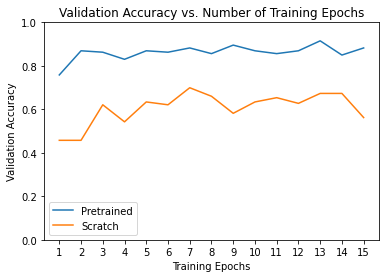

In [19]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = mobilenet_v2(pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()